<a href="https://colab.research.google.com/github/dolmani38/Summary/blob/master/implement_to_class_v0.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2
!pip install keybert


     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.5MB 8.3MB/s 
     |████████████████████████████████| 2.9MB 30.8MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp36-none-any.whl size=86754 sha256=bfd0d2288061020b46b00fbcd54fde3923a9c6fb0662ac1b2262565c5c379a24
  Stored in directory: /root/.cache/pip/wheels/b8/23/85/85d6a9a6c68f0625a1ecdaad903bb0a78df058c10cf74f9de4
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d991a1f8f2702f1ae3383afa6ff3770e1f171c1e65dbf1543c1eb81116c4e081
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 778kB 8.1MB/s 
     |████████████████████████████████| 3.0MB 17.0MB/s 
     |████████████████████████████████| 1.1MB 35.4MB/s 
  Fo

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:

# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))

        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
        # Print New Line on Complete
        if self.ite == self.total: 
            print()

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

#Grammar Discriminator Class

In [8]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBert model."""


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [9]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    #txt = txt.replace('.','. ')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(source_urls=[]):
    ko_sentences_dataset = []
    for url in source_urls:
        raw_text = urllib.request.urlopen(url).read().decode('utf-8')
        ko_sentences_dataset += nltk.sent_tokenize(clean_text(raw_text))

    sentences = []
    labels = []

    for txt in ko_sentences_dataset:
        txt = txt.strip()
        if len(txt) > 40:
            #ko_grammar_dataset.append([txt,1])
            txt = txt.replace('.','')
            sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
            labels.append(1)
            sentences.append(shuffling(txt))
            labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:
    """
    # dataset 주입하고 train해서 사용하는 경우, 
    gd = Grammar_Discriminator(pretraoned_kobert_model_name='monologg/kobert')
    gd.set_dataset(dataset = (sentences,labels))
    gd.train(epochs = 4)


    # 기존에 학습한 모델을 load 할 경우
    gd = Grammar_Discriminator(input_dir = './drive/MyDrive/Colab Notebooks/summary/grammar_check_model')
    
    """

    def __init__(self, pretraoned_kobert_model_name='monologg/kobert', input_dir=None):

        if input_dir is None:
            self.tokenizer = KoBertTokenizer.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)



    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = KoBertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


In [10]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:

    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='xlm-r-large-en-ko-nli-ststb'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similiraty(self, queries, org_text_emb):
        scores = []
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)

        return scores        

In [135]:
from keybert import KeyBERT
key_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [217]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        #txt = txt.replace('.','. ')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.asarray(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode([self.org_text])[0]




        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='word density scan :')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similiraty([part_sen.strip()],self.org_text_emb)[0]
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='story density scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similiraty([part_sen.strip()],self.org_text_emb)[0]
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative words:',terms[dup_order])


        top_n = int(len(self.term_table)/5)

        self.story_peaks = []
        keywords = key_model.extract_keywords(org_text,top_n=top_n)
        print('keywords len',len(keywords))
        for keyword in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame text:',self.frame_text)


    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.asarray(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')


        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode([self.org_text])[0]

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='word density scan :')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similiraty([part_sen.strip()],self.org_text_emb)[0]
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='story density scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similiraty([part_sen.strip()],self.org_text_emb)[0]
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative words:',terms[dup_order])
        terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='story density scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similiraty([part_sen.strip()],self.org_text_emb)[0]
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)
        print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        print(self.story_peaks)
        # story density 표출
        plt.figure(figsize=(12, 6))
        plt.plot(self.story_weights)
        plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
        plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
        plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame text:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similiraty([skel_text.strip()],self.org_text_emb)[0]}')      

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''    
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

In [91]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),

            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            ##nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

In [216]:
import random
import numpy as np


class Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size)

        plt.figure(figsize=(12, 6))
        plt.plot(history['gen_g_loss'],label='generator grammar loss')
        plt.plot(history['gen_s_loss'],label='generator similarity loss')
        if 'dis_loss' in history:
            plt.plot(history['dis_loss'],label='discriminator grammar loss')
        plt.legend()
        plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = self.s_discriminator.similiraty(fake_outs,self.source.org_text_emb)

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])
            fake_sim_out[i,tk] += f_sim_out[j]
            
        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=2e-4)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval()

        self.generator.to(device)      # gpu 메모리 용량 땜에 디짐....    
        self.generator.eval()

        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        #self.source.story_peaks = [1,7,11,12,15,23,30,32,40,43,48,49,51,56,62,79,82,89,91,98,100,101,106,108,114,116,126,127,128]
        for i in range(epochs):

            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += 1#initial_bias
            #with tf.GradientTape() as tape:
            #print(bias)

            #bias = 0
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)
                #sw, sw0 = self.generator(noise)
            initial_bias = -torch.max(sw0)*2
            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            #print('D1_opt.step()')
            if True:
                self.generator.train()     #generator는 train 모드로 전환
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += 1#initial_bias
                #bias = 0
                sw, sw0 = self.generator(noise,bias)
                #sw, sw0 = self.generator(noise)
                initial_bias = -torch.max(sw0)*2
                self.last_bias_max = initial_bias
                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
                
                if i%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    # --> 이게 엄밀히 말하면.. D(G(z)) 은 아닌데... 이걸 수학적으로 어떻게 해석해야 하는가???
                    # grammar loss function...
                    G_g_loss = criterion(sw,fake_gmr_out)
                    # similarity loss function...
                    #G_s_loss = criterion(sw,fake_sim_out)
                    G_loss = G_g_loss #+ G_s_loss
                elif i%2 == 1:
                    # grammar loss function...
                    #G_g_loss = criterion(sw,fake_gmr_out)
                    # similarity loss function...
                    G_s_loss = criterion(sw,fake_sim_out)
                    G_loss = G_s_loss                   

                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            dis_loss_history.append(D_loss.cpu().detach().numpy())

            pb.printProgress(+1,f'{i+1}/{epochs} epochs, Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss},   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        
        plt.figure(figsize=(12, 6))
        plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
        plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
        plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
        plt.legend()        
        plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] -= self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

In [14]:
use_pretrained_model = True

if use_pretrained_model:
    g_discriminator = Grammar_Discriminator(input_dir = './drive/MyDrive/Colab Notebooks/summary/grammar_check_model')
else:
    urls = ['https://raw.githubusercontent.com/dolmani38/Summary/master/data/korean_sample.txt',
            'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-ABC%20%EC%82%B4%EC%9D%B8%EC%82%AC%EA%B1%B4.txt',
            'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EA%B7%B8%EB%A6%AC%EA%B3%A0%20%EC%95%84%EB%AC%B4%EB%8F%84%20%EC%97%86%EC%97%88%EB%8B%A4.txt']
    sentences,labels = collect_training_dataset_for_grammar_discriminator(source_urls=urls)
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=2)
    g_discriminator.save_model()



Loading BERT tokenizer...


In [15]:
s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 1.80G/1.80G [05:45<00:00, 5.20MB/s]


In [204]:
org_text = """나무꾼이 나무를 하다가 숲 속에서 도망치는 사슴을 만났는데, 이 사슴이 사냥꾼이 쫓아오고 있으니 자신을 숨겨달라고 말했다. 말하는 사슴을 신기하게 여긴 나무꾼이 사슴을 숨겨줬고, 뒤쫓아 온 사냥꾼을 다른 방향으로 보내서 구해주었다.
사슴은 은혜를 갚겠다고 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 샘과 선녀들이 목욕을 하러 오는 시기, 선녀의 옷을 훔쳐 그를 아내로 삼도록 하는 꾀를 나무꾼에게 가르쳐 주었다. 나무꾼은 반신반의 하면서도 사슴이 가르쳐준 시기에 선녀들이 목욕을 하러 내려온다는 샘으로 찾아가 몸을 숨겼다. 그렇게 잠시간 기다리자 과연, 선녀들이 하늘에서 내려와 날개옷을 벗고 선녀탕에서 목욕을 하는 것이었다. 나무꾼은 사슴이 가르쳐준 대로 날개옷을 하나 훔쳤다.
날개옷이 없어진 탓에 한 명의 선녀는 하늘로 올라가지 못했으며 다른 선녀들은 날개옷이 없는 선녀를 내버려두고 하늘로 돌아갔다. 이때 나무꾼이 홀로 남은 선녀에게 자신의 아내가 되어달라고 하자, 하늘나라로 올라가지 못하게 된 선녀는 할 수 없이 나무꾼에게 의탁하게 되었다.
"""

In [195]:
org_text = """옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"엄마, 저애를 신데렐라라고 불러야겠어요."
"온통 재투성이잖아요. 호호호!" 두 언니는 소녀를 놀려 댔어요.
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
"신데렐라, 너도 무도회에 가고 싶니?"
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
"내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴."
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
"신데렐라, 발을 내밀어 보거라."
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
"신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?"
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
"이 유리 구두의 주인과 결혼하겠어요."
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
"저도 한번 신어 볼 수 있나요?"
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요."""

In [218]:
source = Source(org_text)
source.extract_keywords(s_discriminator,key_model)
#source.analysis_frame_terms(s_discriminator)

------------------------------------------------------------------
나무꾼이 나무를 하다가 숲 속에서 도망치는 사슴을 만났는데, 이 사슴이 사냥꾼이 쫓아오고 있으니 자신을 숨겨달라고 말했다. 말하는 사슴을 신기하게 여긴 나무꾼이 사슴을 숨겨줬고, 뒤쫓아 온 사냥꾼을 다른 방향으로 보내서 구해주었다. 사슴은 은혜를 갚겠다고 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 샘과 선녀들이 목욕을 하러 오는 시기, 선녀의 옷을 훔쳐 그를 아내로 삼도록 하는 꾀를 나무꾼에게 가르쳐 주었다. 나무꾼은 반신반의 하면서도 사슴이 가르쳐준 시기에 선녀들이 목욕을 하러 내려온다는 샘으로 찾아가 몸을 숨겼다. 그렇게 잠시간 기다리자 과연, 선녀들이 하늘에서 내려와 날개옷을 벗고 선녀탕에서 목욕을 하는 것이었다. 나무꾼은 사슴이 가르쳐준 대로 날개옷을 하나 훔쳤다. 날개옷이 없어진 탓에 한 명의 선녀는 하늘로 올라가지 못했으며 다른 선녀들은 날개옷이 없는 선녀를 내버려두고 하늘로 돌아갔다. 이때 나무꾼이 홀로 남은 선녀에게 자신의 아내가 되어달라고 하자, 하늘나라로 올라가지 못하게 된 선녀는 할 수 없이 나무꾼에게 의탁하게 되었다.
------------------------------------------------------------------
Token table of origin text
---------------------------------------------
 Code     Token     
  0         
  1         나무꾼이
  2         나무를
  3         하다가
  4         숲
  5         속에서
  6         도망치는
  7         사슴을
  8         만났는데,
  9         이
  10        사슴이
  11        사냥꾼이
  12        쫓아오고
  13        있으니
  

Train... |||||||||||||||||||||| 100.0%   100/100 epochs, Generator / grammar loss:0.14912039041519165   similarity loss:0.3798075020313263,   Discriminator grammar_loss:0.0        


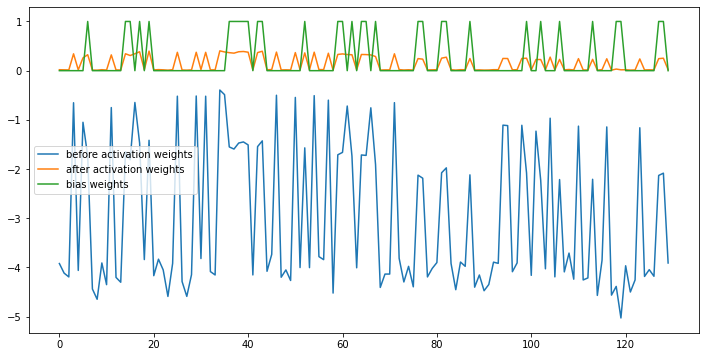

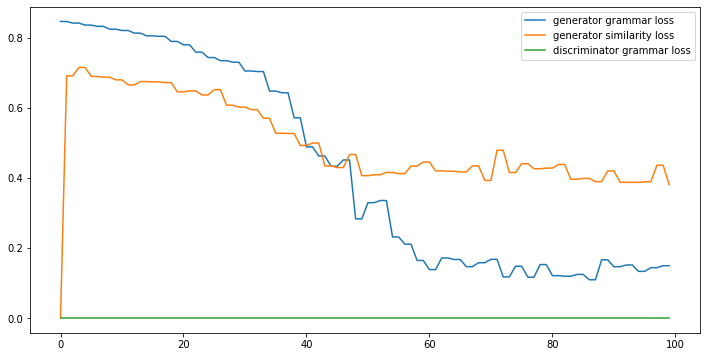

In [221]:
summarizer = Summarizer(g_discriminator,s_discriminator)
#source = Source(org_text)
summarizer.ready(source)
summarizer.summarize(epochs=100,batch_size=2,frame_expansion_ratio = 0.7)

In [220]:
txts = summarizer.get_summary(3)

print('\n'.join(txts))
print(source.frame_text)

나무꾼이 하다가 속에서 도망치는 사냥꾼이 자신을 숨겨달라고 말했다. 말하는 신기하게 온 보내서 사슴은 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 선녀들이 목욕을 오는 시기, 그를 삼도록 꾀를 가르쳐 주었다. 반신반의 하면서도 사슴이 가르쳐준 선녀들이 목욕을 하러 내려온다는 숨겼다. 그렇게 선녀들이 하늘에서 벗고 선녀탕에서 목욕을 하는 가르쳐준 탓에 한 하늘로 올라가지 다른 선녀들은 없는 내버려두고 돌아갔다. 나무꾼이 선녀에게 아내가 되어달라고 하늘나라로 올라가지 할 의탁하게 되었다.
나무꾼이 하다가 속에서 도망치는 사냥꾼이 자신을 숨겨달라고 말했다. 말하는 신기하게 온 보내서 사슴은 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 선녀들이 목욕을 오는 시기, 그를 삼도록 꾀를 가르쳐 주었다. 반신반의 하면서도 사슴이 가르쳐준 선녀들이 목욕을 하러 내려온다는 숨겼다. 그렇게 선녀들이 하늘에서 벗고 선녀탕에서 목욕을 하는 가르쳐준 탓에 한 하늘로 올라가지 다른 선녀들은 없는 내버려두고 돌아갔다. 나무꾼이 선녀에게 아내가 되어달라고 하늘나라로 올라가지 할 의탁하게 되었다.
나무꾼이 하다가 속에서 도망치는 사냥꾼이 자신을 숨겨달라고 말했다. 말하는 신기하게 온 보내서 사슴은 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 선녀들이 목욕을 오는 시기, 그를 삼도록 꾀를 가르쳐 주었다. 반신반의 하면서도 사슴이 가르쳐준 선녀들이 목욕을 하러 내려온다는 숨겼다. 그렇게 선녀들이 하늘에서 벗고 선녀탕에서 목욕을 하는 가르쳐준 탓에 한 하늘로 올라가지 다른 선녀들은 없는 내버려두고 돌아갔다. 나무꾼이 선녀에게 아내가 되어달라고 하늘나라로 올라가지 할 의탁하게 되었다.
도망치는 자신을 숨겨달라고 말하는 신기하게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 선녀들이 목욕을 삼도록 반신반의 하면서도 가르쳐준 선녀들이 목욕을 내려온다는 선녀들이 하늘에서 선녀탕에서 목욕을 가르쳐준 올라가지 선녀들은 내버려두고 선녀에게